In [1]:
import os
import numpy as np
import pandas as pd
import mne
from mne.decoding import SlidingEstimator, cross_val_multiscore
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score
from base import *
from config import *
from mne.beamformer import make_lcmv, apply_lcmv_epochs
from collections import defaultdict
from scipy.stats import ttest_1samp, spearmanr
import matplotlib.pyplot as plt
import gc

In [2]:
# params
trial_types = ["all", "pattern", "random"]
trial_type = 'pattern'
data_path = DATA_DIR
lock = "stim"
subjects = SUBJS
sessions = ['practice', 'b1', 'b2', 'b3', 'b4']
subjects_dir = FREESURFER_DIR
res_path = RESULTS_DIR
folds = 2
chance = 0.5
threshold = 0.05
scoring = "accuracy"
scoring = "roc_auc"
parc='aparc'
hemi = 'both'
params = "pred_decoding"
verbose = True
jobs = -1
decim = False

plt.style.use('dark_background')

# figures dir
figures = RESULTS_DIR / 'figures' / lock / params / 'source' / trial_type
ensure_dir(figures)
# get times
epoch_fname = DATA_DIR / lock / 'sub01_0_s-epo.fif'
epochs = mne.read_epochs(epoch_fname, verbose=verbose)
times = epochs.times
if decim:
    times = times[::3]
del epochs
gc.collect()

Reading /Users/coum/Library/CloudStorage/OneDrive-etu.univ-lyon1.fr/asrt/preprocessed/stim/sub01_0_s-epo.fif ...
    Found the data of interest:
        t =    -196.61 ...     599.65 ms
        0 CTF compensation matrices available
Not setting metadata
115 matching events found
No baseline correction applied
0 projection items activated


7740

In [3]:
subject = subjects[0]
# get labels
labels = mne.read_labels_from_annot(subject=subject, parc=parc, hemi=hemi, subjects_dir=subjects_dir, verbose=verbose)
# label = labels[ilabel]
        
session_id, session = 0, sessions[0]
# read stim epoch
epoch_fname = data_path / lock / f"{subject}_{session_id}_s-epo.fif"
epoch = mne.read_epochs(epoch_fname, preload=True, verbose=True)
# read behav
behav_fname = data_path / "behav" / f"{subject}_{session_id}.pkl"
behav = pd.read_pickle(behav_fname).reset_index()    
# get session behav and epoch
if session_id == 0:
    session = 'prac'
else:
    session = 'sess-%s' % (str(session_id).zfill(2))

if lock == 'button': 
    epoch_bsl_fname = data_path / "bsl" / f"{subject}_{session_id}_bl-epo.fif"
    epoch_bsl = mne.read_epochs(epoch_bsl_fname, verbose=verbose)
# read forward solution    
fwd_fname = res_path / "fwd" / lock / f"{subject}-fwd-{session_id}.fif"
fwd = mne.read_forward_solution(fwd_fname, verbose=verbose)
# compute data covariance matrix on evoked data
data_cov = mne.compute_covariance(epoch, tmin=0, tmax=.6, method="empirical", rank="info", verbose=verbose)
# compute noise covariance
if lock == 'button':
    noise_cov = mne.compute_covariance(epoch_bsl, method="empirical", rank="info", verbose=verbose)
else:
    noise_cov = mne.compute_covariance(epoch, tmin=-.2, tmax=0, method="empirical", rank="info", verbose=verbose)
info = epoch.info
# conpute rank
rank = mne.compute_rank(noise_cov, info=info, rank=None, tol_kind='relative', verbose=verbose)
# compute source estimate
filters = make_lcmv(info, fwd, data_cov=data_cov, noise_cov=noise_cov,
                pick_ori=None, rank=rank, reduce_rank=True, verbose=verbose)
stcs = apply_lcmv_epochs(epoch, filters=filters, verbose=verbose)

del epoch, fwd, data_cov, noise_cov, rank, filters
gc.collect()


Reading labels from parcellation...
   read 34 labels from /Users/coum/Library/CloudStorage/OneDrive-etu.univ-lyon1.fr/asrt/freesurfer/sub01/label/lh.aparc.annot
   read 34 labels from /Users/coum/Library/CloudStorage/OneDrive-etu.univ-lyon1.fr/asrt/freesurfer/sub01/label/rh.aparc.annot
Reading /Users/coum/Library/CloudStorage/OneDrive-etu.univ-lyon1.fr/asrt/preprocessed/stim/sub01_0_s-epo.fif ...
    Found the data of interest:
        t =    -196.61 ...     599.65 ms
        0 CTF compensation matrices available
Not setting metadata
115 matching events found
No baseline correction applied
0 projection items activated
Reading forward solution from /Users/coum/Library/CloudStorage/OneDrive-etu.univ-lyon1.fr/asrt/results/fwd/stim/sub01-fwd-0.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...


/var/folders/y_/m3qn82z15yb4fhdtdwn9vp_h0000gq/T/ipykernel_1782/1439677120.py:24: RuntimeWarning: This filename (/Users/coum/Library/CloudStorage/OneDrive-etu.univ-lyon1.fr/asrt/results/fwd/stim/sub01-fwd-0.fif) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif, _fwd.fif.gz, -fwd.h5 or _fwd.h5
  fwd = mne.read_forward_solution(fwd_fname, verbose=verbose)


    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (8196 sources, 246 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Computing rank from data with rank='info'
    MAG: rank 246 after 0 projectors applied to 246 channels
Reducing data rank from 246 -> 246
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 14145
[done]
Computing rank from data with rank='info'
    MAG: rank 246 after 0 projectors applied to 246 channels
Reducing data rank from 246 -> 246
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 4715
[done]
Computing rank from covariance with rank=None
    Using tolerance 1e-13 (2.2e-16 eps * 246 dim * 1.9  max singular value)
    Estimated rank (mag): 2

17749

In [4]:
ilabel, label = 6, labels[6]
print(f"{ilabel+1}/{len(labels)}", subject, session, label.name)

# get stcs in label
stcs_data = [stc.in_label(label).data for stc in stcs]
stcs_data = np.array(stcs_data)
assert len(stcs_data) == len(behav)

if trial_type == 'pattern':
    pattern = behav.trialtypes == 1
    X = stcs_data[pattern]
    y = behav.positions[pattern]
elif trial_type == 'random':
    random = behav.trialtypes == 2
    X = stcs_data[random]
    y = behav.positions[random]
else:
    X = stcs_data
    y = behav.positions
y = y.reset_index(drop=True).to_numpy()            
assert X.shape[0] == y.shape[0]

if decim:                 
    X = X[:, :, ::3]

print("X shape:", X.shape, "(n_trials, n_vertices, n_time_points)")

7/68 sub01 prac cuneus-lh
X shape: (51, 58, 163) (n_trials, n_vertices, n_time_points)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.1, random_state=42)

In [6]:
X_train = X_train.swapaxes(1, 2)
X_train = X_train.reshape(-1, X_train.shape[-1])
X_test = X_test.swapaxes(1, 2)
X_test_original = X_test.copy()
X_test = X_test.reshape(-1, X_test.shape[-1])

y_train = y_train.repeat(X.shape[-1]) - 1
y_test = y_test.repeat(X.shape[-1]) - 1
y_test_original = y_test.copy()

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)

print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (7335, 58)
y_train shape:  (7335,)
X_test shape:  (978, 58)
y_test shape:  (978,)


In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Normalization, LSTM
from tensorflow.keras.optimizers import Adam

# To save best model

ckpt_fname = res_path / "ckpt"
ensure_dir(ckpt_fname)

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=ckpt_fname,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [15]:
epochs = 100

normalizer = Normalization(axis=-1) # axis set to features axis to normalize each one independently
normalizer.adapt(X_train)

# Assuming X is already reshaped to (n_samples * n_time_points, n_features)
model = Sequential([
    normalizer,
    Dense(10, input_shape = (X_train.shape[-1],)),
    # Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

model.compile(optimizer=keras.optimizers.Adam(0.01),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    validation_split=0.1, 
                    batch_size=X_train.shape[0],
                    callbacks=[model_checkpoint_callback])

# Evaluate the model
accuracy = model.evaluate(X_test, y_test)[1]
print(f"Test Accuracy: {accuracy * 100:.2f}%")

y_pred = model.predict(X_test)

Epoch 1/100
1/1 [==============================] - 0s 394ms/step - loss: 1.7530 - accuracy: 0.2619 - val_loss: 1.7057 - val_accuracy: 0.2289
Epoch 2/100
1/1 [==============================] - 0s 24ms/step - loss: 1.5804 - accuracy: 0.2883 - val_loss: 1.6864 - val_accuracy: 0.1935
Epoch 3/100
1/1 [==============================] - 0s 23ms/step - loss: 1.5807 - accuracy: 0.2909 - val_loss: 1.6230 - val_accuracy: 0.1771
Epoch 4/100
1/1 [==============================] - 0s 23ms/step - loss: 1.5071 - accuracy: 0.2900 - val_loss: 1.5628 - val_accuracy: 0.1812
Epoch 5/100
1/1 [==============================] - 0s 23ms/step - loss: 1.4374 - accuracy: 0.2850 - val_loss: 1.5275 - val_accuracy: 0.1826
Epoch 6/100
1/1 [==============================] - 0s 23ms/step - loss: 1.4188 - accuracy: 0.2853 - val_loss: 1.5032 - val_accuracy: 0.1962
Epoch 7/100
1/1 [==============================] - 0s 23ms/step - loss: 1.4244 - accuracy: 0.2787 - val_loss: 1.4755 - val_accuracy: 0.2207
Epoch 8/100
1/1 [==

accuracy score:  0.25357873210633947


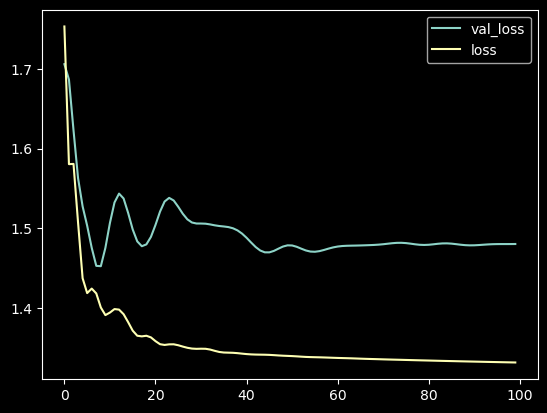

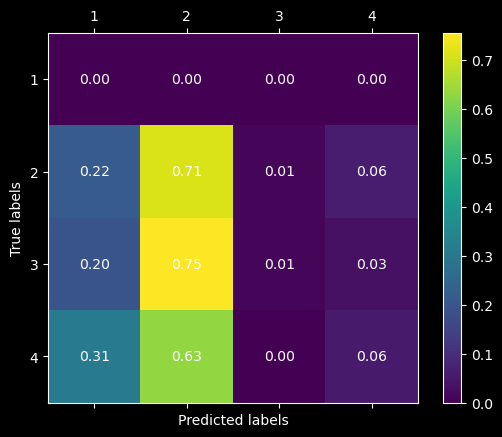

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

predicted_class_labels = np.argmax(y_pred, axis=1)
print("accuracy score: ", accuracy_score(y_test, predicted_class_labels))

plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.show()

conf_mat = confusion_matrix(y_test.astype('int64'),predicted_class_labels.astype('int64'), normalize='true')
# Print confusion matrix
fig2 = plt.figure()
ax = fig2.add_subplot(111)
cax = ax.matshow(conf_mat)
for (i, j), value in np.ndenumerate(np.swapaxes(conf_mat,0,1)):
    plt.text(i, j, f"{value:.2f}", va="center", ha="center",c="white")
ax.set_xticks(range(4))
ax.set_xticklabels(range(5)[1:])
ax.set_yticks(range(4))
ax.set_yticklabels(range(5)[1:])
fig2.colorbar(cax)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [17]:
# model = keras.models.load_model(ckpt_fname)

n_time_points = X.shape[-1]
accuracies = []
for t in range(n_time_points):
    # Select the data for the t-th time point across all samples
    X_test_t = X_test_original[:, t, :]

    # Model prediction
    y_pred_t = model.predict(X_test_t)
    y_pred_labels_t = np.argmax(y_pred_t, axis=1)

    # Select the correct labels for comparison
    y_test_t = y_test[::n_time_points]

    # Calculate accuracy
    accuracy_t = np.mean(y_pred_labels_t == y_test_t)
    accuracies.append(accuracy_t)


1/1 [==============================] - 0s 16ms/step


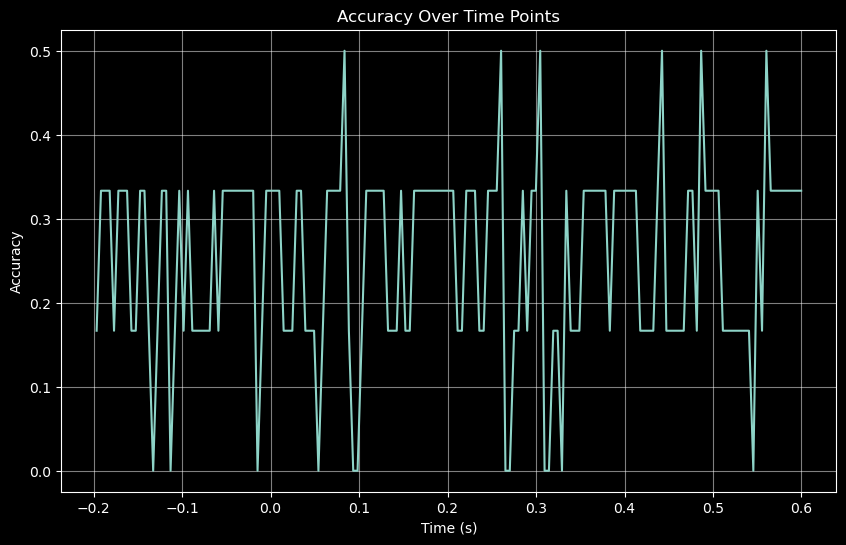

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(times, accuracies)
plt.title('Accuracy Over Time Points')
plt.xlabel('Time (s)')
plt.ylabel('Accuracy')
plt.grid(True, alpha=.5)
plt.show()


In [92]:
X_rnn = X.swapaxes(1, 2)
y_fix = y - 1
xtrain, xtest, ytrain, ytest = train_test_split(X_rnn, y_fix, test_size=0.2, random_state=42)

normalizer = keras.layers.Normalization(axis=1)
normalizer.adapt(xtrain)

In [98]:
from keras.layers import LSTM

epochs = 200

model = keras.Sequential(
    [
        keras.Input(shape=(xtrain.shape[1:])),
        normalizer,
        LSTM(4, activation="softmax", return_sequences=False),
        # layers.Dropout(0.2),
        # layers.Dense(24, activation='relu'),
    ]
)

model.summary()
model.compile(optimizer=keras.optimizers.Adam(0.00001),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

history = model.fit(xtrain, ytrain, 
                    epochs=epochs, 
                    validation_split=0.2, 
                    batch_size=xtrain.shape[0], 
                    callbacks=[model_checkpoint_callback])

ypred = model.predict(xtest)
print(model.summary)

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_15 (Normaliza  (None, 163, 58)          327       
 tion)                                                           
                                                                 
 lstm_24 (LSTM)              (None, 4)                 1008      
                                                                 
Total params: 1,335
Trainable params: 1,008
Non-trainable params: 327
_________________________________________________________________
Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 2.1253 - accuracy: 0.1250 - val_loss: 1.9702 - val_accuracy: 0.0000e+00
Epoch 2/200
1/1 [==============================] - 0s 53ms/step - loss: 2.1247 - accuracy: 0.1250 - val_loss: 1.9697 - val_accuracy: 0.0000e+00
Epoch 3/200
1/1 [==============================] - 0s 55ms/step - loss: 2.1241 - accuracy: 0.

accuracy score:  0.18181818181818182


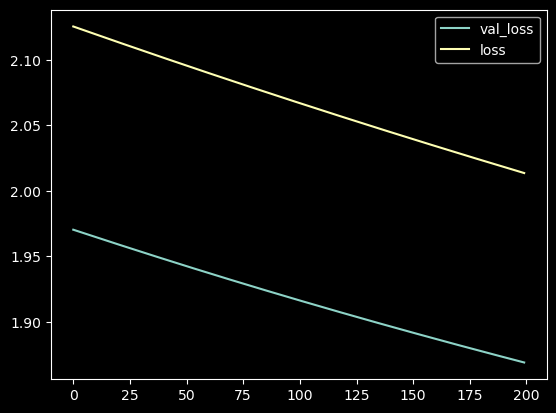

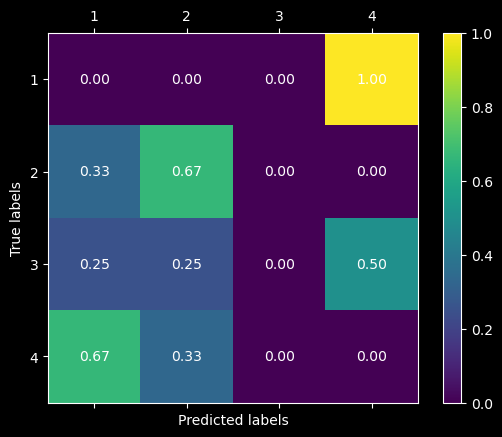

In [99]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

predicted_class_labels = np.argmax(ypred, axis=1)
print("accuracy score: ", accuracy_score(ytest, predicted_class_labels))

plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.show()

conf_mat = confusion_matrix(ytest.astype('int64'),predicted_class_labels.astype('int64'), normalize='true')
# Print confusion matrix
fig2 = plt.figure()
ax = fig2.add_subplot(111)
cax = ax.matshow(conf_mat)
for (i, j), value in np.ndenumerate(np.swapaxes(conf_mat,0,1)):
    plt.text(i, j, f"{value:.2f}", va="center", ha="center",c="white")
ax.set_xticks(range(4))
ax.set_xticklabels(range(5)[1:])
ax.set_yticks(range(4))
ax.set_yticklabels(range(5)[1:])
fig2.colorbar(cax)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [69]:
loss, accuracy = model.evaluate(xtest, ytest)

1/1 [==============================] - 0s 29ms/step - loss: 1.5885 - accuracy: 0.3333


In [70]:
accuracies = []
for t in range(n_time_points):
    correct_preds = np.argmax(ypred[:, t, :], axis=1) == np.argmax(ytest[:, t, :], axis=1)
    accuracy_t = np.mean(correct_preds)
    accuracies.append(accuracy_t)


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed